# Circlipses revisited

## Overview

'Circlipses' is a previously published study between myself and Ariane Rhone (University of Iowa) that involved, blood, sweat, tears, and territorial fights over the keyboard. And also novel stimuli and analyses, resulting in several citations. It was an arduous process, resulting in at least one of us saying we would never be caught doing another audio-visual integration project again.

So why revisit this? A few reasons:
- more in-depth statistical knowledge
- an opportunity to use advances in Linear Mixed Model (LMM) fitting
- better knowledge of how to fit LMMs
- application of more advanced analyses that are almost never considered in the literature and that may be adopted slowly

So to that end, the data and results will be revisited with:
- better summation calls and visualizations
- better distribution plots
- better LMM calls (introducing random slopes mostly)
- analysis of residuals
- Bayesian inference on the dependent variable

Details can be found in _**Brain Topography, Vol 24, Issue 2 pp. 134-148**_ (see also the references at the end).

## Data

**Factors**: ```Subject, Hemipshere, Harmonic, Condition, Area```  
**Numeric variables**: ```LinPwr, dBPwr```  
**14 Subjects total analyzed**  
Analyses focus on **_dBPwr_**: power is decibels is more normally distributed

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

library(readr)
data.path <- 
  'https://raw.githubusercontent.com/julian3rd/circlipses-revisited/master/data/circlipse-pwr-data-final-2015.csv'
circlipse.pwr.data <- read_csv(data.path, col_names = TRUE)

str(circlipse.pwr.data)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	672 obs. of  7 variables:
 $ Subject: chr  "r1532" "r1532" "r1532" "r1532" ...
 $ Hem    : chr  "1-lh" "1-lh" "1-lh" "1-lh" ...
 $ Harm   : chr  "1-Fm" "1-Fm" "1-Fm" "1-Fm" ...
 $ Cond   : chr  "1-Uni" "1-Uni" "1-Uni" "2-Zero" ...
 $ Area   : chr  "1-AntTem" "2-PosTem" "3-Occ" "1-AntTem" ...
 $ LinPwr : num  4.31e+15 2.89e+15 2.97e+18 4.37e+16 2.06e+17 ...
 $ dBPwr  : num  156 155 185 166 173 ...


In [3]:
%R print(summary(circlipse.pwr.data))

   Subject              Hem                Harm               Cond          
 Length:672         Length:672         Length:672         Length:672        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
     Area               LinPwr              dBPwr      
 Length:672         Min.   :2.010e+12   Min.   :123.0  
 Class :character   1st Qu.:1.538e+15   1st Qu.:151.8  
 Mode  :character   Median :6.935e+15   Median :158.2  
                    Mean   :6.134e+16   Mean   :158.2  
                    3rd Qu.:3.590e+16   3rd Qu.:165.5  
                    Max.   :2.970e+18   Max.   :184.7  


In [4]:
%R print(head(circlipse.pwr.data, n = 21))

   Subject  Hem         Harm     Cond     Area   LinPwr    dBPwr
1    r1532 1-lh         1-Fm    1-Uni 1-AntTem 4.31e+15 156.3465
2    r1532 1-lh         1-Fm    1-Uni 2-PosTem 2.89e+15 154.6139
3    r1532 1-lh         1-Fm    1-Uni    3-Occ 2.97e+18 184.7343
4    r1532 1-lh         1-Fm   2-Zero 1-AntTem 4.37e+16 166.4076
5    r1532 1-lh         1-Fm   2-Zero 2-PosTem 2.06e+17 173.1442
6    r1532 1-lh         1-Fm   2-Zero    3-Occ 1.61e+18 182.0758
7    r1532 1-lh         1-Fm 3-HalfPi 1-AntTem 3.01e+16 164.7860
8    r1532 1-lh         1-Fm 3-HalfPi 2-PosTem 7.46e+16 168.7260
9    r1532 1-lh         1-Fm 3-HalfPi    3-Occ 1.25e+18 180.9726
10   r1532 1-lh         1-Fm     4-Pi 1-AntTem 8.73e+16 169.4108
11   r1532 1-lh         1-Fm     4-Pi 2-PosTem 2.26e+17 173.5503
12   r1532 1-lh         1-Fm     4-Pi    3-Occ 7.52e+17 178.7608
13   r1532 1-lh 2-SecondHarm    1-Uni 1-AntTem 1.59e+15 152.0129
14   r1532 1-lh 2-SecondHarm    1-Uni 2-PosTem 6.68e+15 158.2478
15   r1532 1-lh 2-SecondH

In [5]:
%%R
circlipse.pwr.data$Hem <- as.factor(circlipse.pwr.data$Hem)
circlipse.pwr.data$Harm <- as.factor(circlipse.pwr.data$Harm)
circlipse.pwr.data$Cond <- as.factor(circlipse.pwr.data$Cond)
circlipse.pwr.data$Area <- as.factor(circlipse.pwr.data$Area)

## Means and standard errors
To initially explore the data, let's first look at a central moment (the mean) and the uncertainity associated with it.

Means and standard errors for:
- each hemisphere
- each experimental condition
- each sensor area
- each harmonic
- sensor area x harmonic

### Hemisphere

In [6]:
%%R 

library(plyr)

hem.pwr <- 
ddply(circlipse.pwr.data, .(Hem), summarize, 
      n = sum(complete.cases(dBPwr)), 
      meanPwr = mean(dBPwr, na.rm = TRUE), 
      sePwr = sd(dBPwr,na.rm = TRUE)/sqrt(n))

print(hem.pwr)

   Hem   n  meanPwr     sePwr
1 1-lh 336 158.4264 0.5918377
2 2-rh 336 157.9267 0.5640578


### Condition

In [7]:
%%R
cond.pwr <- 
ddply(circlipse.pwr.data, .(Cond), summarize, 
      n = sum(complete.cases(dBPwr)), 
      meanPwr = mean(dBPwr, na.rm = TRUE), 
      sePwr = sd(dBPwr,na.rm = TRUE)/sqrt(n))

print(cond.pwr)

      Cond   n  meanPwr     sePwr
1    1-Uni 168 157.5322 0.7388522
2   2-Zero 168 158.4006 0.8311643
3 3-HalfPi 168 158.5020 0.8371437
4     4-Pi 168 158.2715 0.8615170


### Sensor area

In [8]:
%%R 
sensor.pwr <- 
ddply(circlipse.pwr.data, .(Area), summarize, 
      n = sum(complete.cases(dBPwr)), 
      meanPwr = mean(dBPwr, na.rm = TRUE),  
      sePwr = sd(dBPwr,na.rm = TRUE)/sqrt(n))
print(sensor.pwr)

      Area   n  meanPwr     sePwr
1 1-AntTem 224 151.2190 0.7140157
2 2-PosTem 224 160.8796 0.5729475
3    3-Occ 224 162.4311 0.5813470


### Harmonic

In [9]:
%%R
harm.pwr <- 
ddply(circlipse.pwr.data, .(Harm), summarize, 
      n = sum(complete.cases(dBPwr)), 
      meanPwr = mean(dBPwr, na.rm = TRUE),  
      sePwr = sd(dBPwr,na.rm = TRUE)/sqrt(n))
print(harm.pwr)

          Harm   n  meanPwr     sePwr
1         1-Fm 336 161.8573 0.5430409
2 2-SecondHarm 336 154.4958 0.5413204


###Sensor area x Harmonic

In [10]:
%%R 
sensor.harm.pwr <- 
ddply(circlipse.pwr.data, .(Area, Harm), summarize, 
      n = sum(complete.cases(dBPwr)), 
      meanPwr = mean(dBPwr, na.rm = TRUE),  
      sePwr = sd(dBPwr,na.rm = TRUE)/sqrt(n))
print(sensor.harm.pwr)

      Area         Harm   n  meanPwr     sePwr
1 1-AntTem         1-Fm 112 155.8708 1.0101321
2 1-AntTem 2-SecondHarm 112 146.5671 0.7988675
3 2-PosTem         1-Fm 112 164.0073 0.7605523
4 2-PosTem 2-SecondHarm 112 157.7518 0.7511877
5    3-Occ         1-Fm 112 165.6939 0.7576669
6    3-Occ 2-SecondHarm 112 159.1683 0.7694643


## Mean and standard error plots

In [11]:
%%R 
# set up plots
library(ggplot2)

# dodge for error bars
dodge <- position_dodge(width = 0.9)

# color-blind friendly palette, as desscribed by Winston Chang
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

###Hemisphere

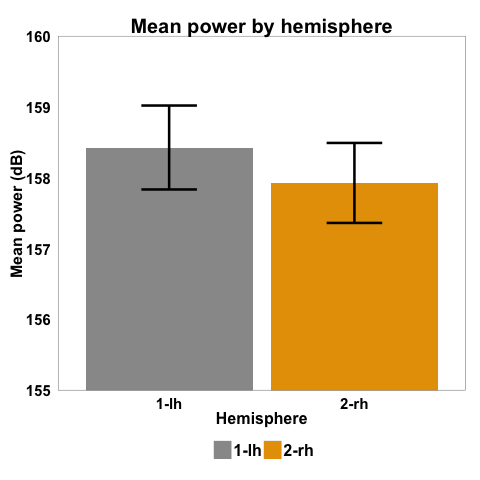

In [12]:
%%R 

ggplot(hem.pwr, aes(x = Hem, y = meanPwr, fill = Hem, group = Hem)) +
  geom_bar(stat = 'identity', position = 'dodge', size = 1.3) + 
  geom_errorbar(size = 1.2, colour = 'black', 
                aes(ymin = meanPwr - sePwr, ymax = meanPwr + sePwr),
                position = dodge, width = 0.3) +
  theme_bw() +
  labs(x = 'Hemisphere', y = 'Mean power (dB)',
       title = 'Mean power by hemisphere',
       fill = 'Hemisphere', colour = 'Hemisphere', face = 'bold', size = 20) +
  scale_fill_manual(values = cbPalette) + 
  scale_colour_manual(values = cbPalette) + 
  theme(legend.position = 'bottom',
        legend.text = element_text(face = 'bold', size = 16),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 15, face = 'bold'),
        axis.text.y = element_text(size = 15,face = 'bold'),
        axis.ticks = element_blank(),
        axis.title.x = element_text(size = 16, face = 'bold'),
        axis.title.y = element_text(size = 16, face = 'bold'),
        panel.grid.minor.x = element_blank(), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank(),
        plot.title = element_text(size = 20, face = 'bold')) +
  coord_cartesian(ylim = c(155, 160))

###Condition

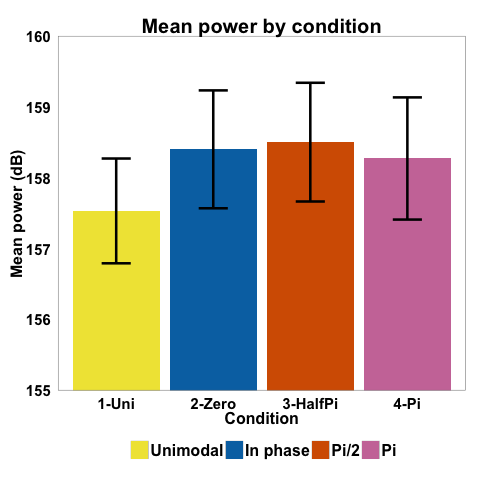

In [13]:
%%R 

ggplot(cond.pwr, aes(x = Cond, y = meanPwr, fill = Cond, group = Cond)) +
  geom_bar(stat = 'identity', position = 'dodge', size = 1.3) + 
  geom_errorbar(size = 1.2, colour = 'black', 
                aes(ymin = meanPwr - sePwr, ymax = meanPwr + sePwr),
                position = dodge, width = 0.3) +
  theme_bw() +
  labs(x = 'Condition', y = 'Mean power (dB)',
       title = 'Mean power by condition',
       fill = 'Harmonic', colour = 'Harmonic', face = 'bold', size = 20) +
  scale_fill_manual(values = c(cbPalette[5], cbPalette[6],
                               cbPalette[7], cbPalette[8]),
                    labels = c('Unimodal', 'In phase',
                               'Pi/2', 'Pi')) + 
  scale_colour_manual(values = c(cbPalette[5], cbPalette[6],
                                 cbPalette[7], cbPalette[8]),
                      labels = c('Unimodal', 'In phase',
                                 'Pi/2', 'Pi')) + 
  theme(legend.position = 'bottom',
        legend.text = element_text(face = 'bold', size = 16),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 15, face = 'bold'),
        axis.text.y = element_text(size = 15,face = 'bold'),
        axis.ticks = element_blank(),
        axis.title.x = element_text(size = 16, face = 'bold'),
        axis.title.y = element_text(size = 16, face = 'bold'),
        panel.grid.minor.x = element_blank(), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank(),
        plot.title = element_text(size = 20, face = 'bold')) +
  coord_cartesian(ylim = c(155, 160))

###Harmonic

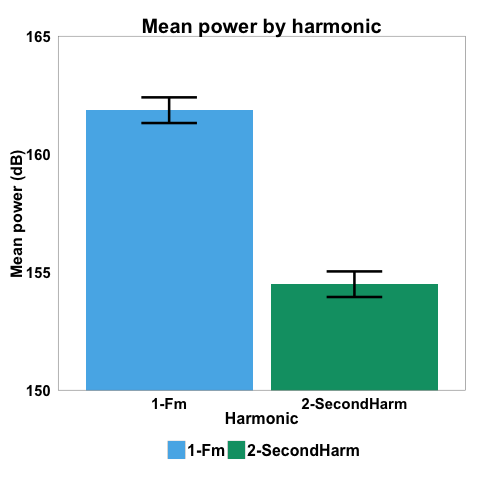

In [14]:
%%R 

ggplot(harm.pwr, aes(x = Harm, y = meanPwr, fill = Harm, group = Harm)) +
  geom_bar(stat = 'identity', position = 'dodge', size = 1.3) + 
  geom_errorbar(size = 1.2, colour = 'black', 
                aes(ymin = meanPwr - sePwr, ymax = meanPwr + sePwr),
                position = dodge, width = 0.3) +
  theme_bw() +
  labs(x = 'Harmonic', y = 'Mean power (dB)',
       title = 'Mean power by harmonic',
       fill = 'Harmonic', colour = 'Harmonic', face = 'bold', size = 20) +
  scale_fill_manual(values = c(cbPalette[3], cbPalette[4])) + 
  scale_colour_manual(values = c(cbPalette[3], cbPalette[4])) + 
  theme(legend.position = 'bottom',
        legend.text = element_text(face = 'bold', size = 16),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 15, face = 'bold'),
        axis.text.y = element_text(size = 15,face = 'bold'),
        axis.ticks = element_blank(),
        axis.title.x = element_text(size = 16, face = 'bold'),
        axis.title.y = element_text(size = 16, face = 'bold'),
        panel.grid.minor.x = element_blank(), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank(),
        plot.title = element_text(size = 20, face = 'bold')) +
  coord_cartesian(ylim = c(150, 165))

###Sensor area

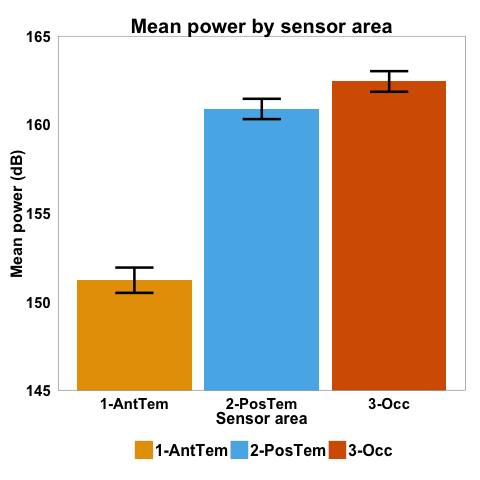

In [15]:
%%R 
ggplot(sensor.pwr, aes(x = Area, y = meanPwr, fill = Area, group = Area)) +
  geom_bar(stat = 'identity', position = 'dodge', size = 1.3) + 
  geom_errorbar(size = 1.2, colour = 'black', 
                aes(ymin = meanPwr - sePwr, ymax = meanPwr + sePwr),
                position = dodge, width = 0.3) +
  theme_bw() +
  labs(x = 'Sensor area', y = 'Mean power (dB)',
       title = 'Mean power by sensor area',
       fill = 'Area', colour = 'Area', face = 'bold', size = 20) +
  scale_fill_manual(values = c(cbPalette[2], cbPalette[3],
                               cbPalette[7])) + 
  scale_colour_manual(values = c(cbPalette[2], cbPalette[3],
                                 cbPalette[7])) + 
  theme(legend.position = 'bottom',
        legend.text = element_text(face = 'bold', size = 16),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 15, face = 'bold'),
        axis.text.y = element_text(size = 15,face = 'bold'),
        axis.ticks = element_blank(),
        axis.title.x = element_text(size = 16, face = 'bold'),
        axis.title.y = element_text(size = 16, face = 'bold'),
        panel.grid.minor.x = element_blank(), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank(),
        plot.title = element_text(size = 20, face = 'bold')) +
  coord_cartesian(ylim = c(145, 165))

###Sensor area x Harmonic

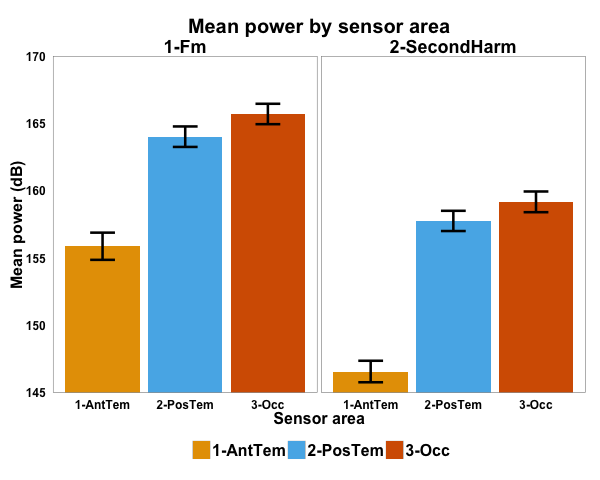

In [16]:
%%R -w 600 -h 480 -u px

ggplot(sensor.harm.pwr, aes(x = Area, y = meanPwr, fill = Area, group = Area)) +
  geom_bar(stat = 'identity', position = 'dodge', size = 1.3) + 
  geom_errorbar(size = 1.2, colour = 'black', 
                aes(ymin = meanPwr - sePwr, ymax = meanPwr + sePwr),
                position = dodge, width = 0.3) +
  theme_bw() +
  labs(x = 'Sensor area', y = 'Mean power (dB)',
       title = 'Mean power by sensor area',
       fill = 'Area', colour = 'Area', face = 'bold', size = 20) +
  scale_fill_manual(values = c(cbPalette[2], cbPalette[3],
                               cbPalette[7])) + 
  scale_colour_manual(values = c(cbPalette[2], cbPalette[3],
                                 cbPalette[7])) + 
  theme(strip.text = element_text(face = 'bold', size = rel(1.5)),
        strip.background=element_rect(fill = 'white', 
                                      colour = 'white', size = 1),
        legend.position = 'bottom',
        legend.text = element_text(face = 'bold', size = 16),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 12, face = 'bold'),
        axis.text.y = element_text(size = 12,face = 'bold'),
        axis.ticks = element_blank(),
        axis.title.x = element_text(size = 16, face = 'bold'),
        axis.title.y = element_text(size = 16, face = 'bold'),
        panel.grid.minor.x = element_blank(), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank(),
        plot.title = element_text(size = 20, face = 'bold')) +
  coord_cartesian(ylim = c(145, 170)) +
  facet_grid(. ~ Harm)

## So what have we seen?

The mean and standard errors indicate several things:  
- likely no difference in power between hemisphere
- likely no difference in power between conditions
- there is a likely difference in power between the harmonics
- there is a likely difference in power between sensor areas
- there is a likely sensor area x harmonic interaction that could be significant

But we cannot move onto modeling just yet. We should look at the distribution of values via kernel density estimates (KDEs) of the values.

##Kernel densty estimates of response power
I tend to use these first and opposed to histograms and boxplots because (1) number of bins/ bin widths can make a huge difference on how the data are represented and (2) normal approximations can be misleading. So I find KDEs give a nice tradeoff (but are not perfect) between the two issues.

### Hemisphere

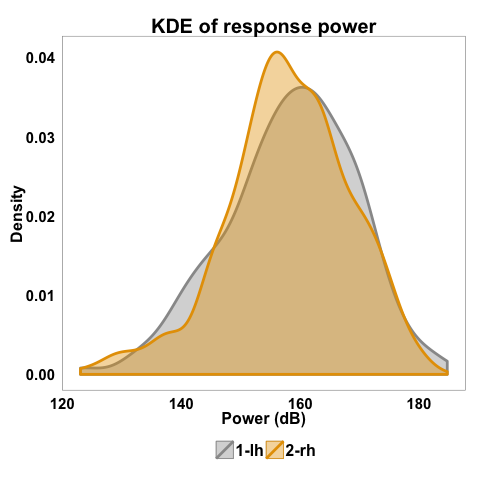

In [17]:
%%R

ggplot(circlipse.pwr.data, aes(x = dBPwr)) +
  geom_density(aes(colour = Hem, fill = Hem), size = 1.3, alpha = 0.4) +
  labs(title = 'KDE of response power', x = 'Power (dB)', y = 'Density') +
  theme_bw() +
  scale_fill_manual(values = cbPalette) + 
  scale_colour_manual(values = cbPalette) + 
  theme(legend.position = 'bottom',
        legend.text = element_text(face = 'bold', size = 16),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 15, face = 'bold'),
        axis.text.y = element_text(size = 15,face = 'bold'),
        axis.ticks = element_blank(),
        axis.title.x = element_text(size = 16, face = 'bold'),
        axis.title.y = element_text(size = 16, face = 'bold'),
        panel.grid.minor.x = element_blank(), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank(),
        plot.title = element_text(size = 20, face = 'bold'))

###Condition

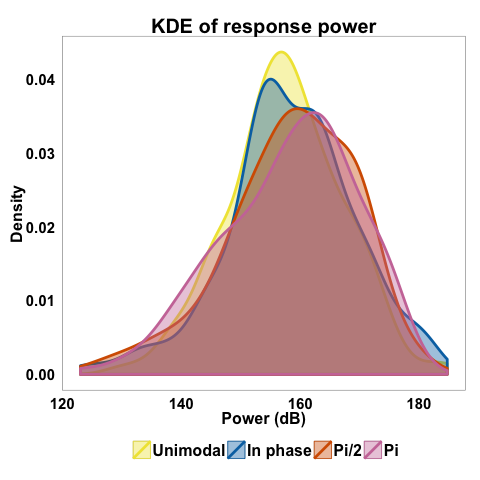

In [18]:
%%R 

ggplot(circlipse.pwr.data, aes(x = dBPwr)) +
  geom_density(aes(colour = Cond, fill = Cond), size = 1.3, alpha = 0.4) +
  labs(title = 'KDE of response power', x = 'Power (dB)', y = 'Density') +
  theme_bw() +
  scale_fill_manual(values = c(cbPalette[5], cbPalette[6],
                               cbPalette[7], cbPalette[8]),
                    labels = c('Unimodal', 'In phase',
                               'Pi/2', 'Pi')) + 
  scale_colour_manual(values = c(cbPalette[5], cbPalette[6],
                               cbPalette[7], cbPalette[8]),
                    labels = c('Unimodal', 'In phase',
                               'Pi/2', 'Pi')) + 
  theme(legend.position = 'bottom',
        legend.text = element_text(face = 'bold', size = 16),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 15, face = 'bold'),
        axis.text.y = element_text(size = 15,face = 'bold'),
        axis.ticks = element_blank(),
        axis.title.x = element_text(size = 16, face = 'bold'),
        axis.title.y = element_text(size = 16, face = 'bold'),
        panel.grid.minor.x = element_blank(), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank(),
        plot.title = element_text(size = 20, face = 'bold'))

###Harmonic

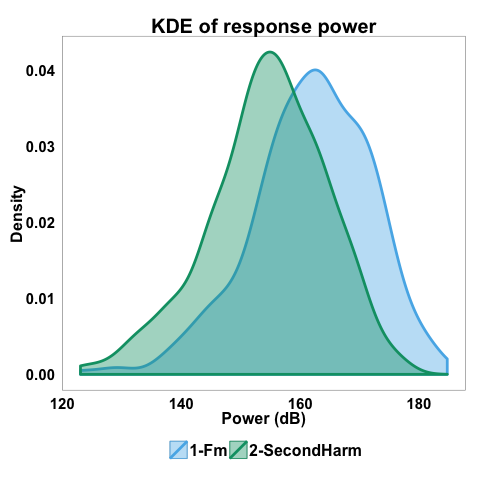

In [19]:
%%R

ggplot(circlipse.pwr.data, aes(x = dBPwr)) +
  geom_density(aes(colour = Harm, fill = Harm), size = 1.3, alpha = 0.4) +
  labs(title = 'KDE of response power', x = 'Power (dB)', y = 'Density') +
  theme_bw() +
  scale_fill_manual(values = c(cbPalette[3], cbPalette[4])) + 
  scale_colour_manual(values = c(cbPalette[3], cbPalette[4])) + 
  theme(legend.position = 'bottom',
        legend.text = element_text(face = 'bold', size = 16),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 15, face = 'bold'),
        axis.text.y = element_text(size = 15,face = 'bold'),
        axis.ticks = element_blank(),
        axis.title.x = element_text(size = 16, face = 'bold'),
        axis.title.y = element_text(size = 16, face = 'bold'),
        panel.grid.minor.x = element_blank(), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank(),
        plot.title = element_text(size = 20, face = 'bold'))

###Sensor area

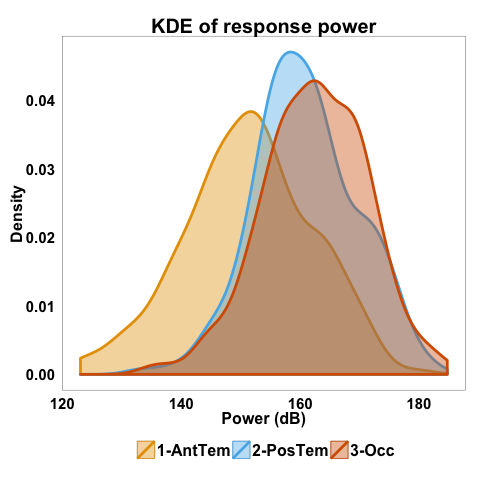

In [20]:
%%R 

ggplot(circlipse.pwr.data, aes(x = dBPwr)) +
  geom_density(aes(colour = Area, fill = Area), size = 1.3, alpha = 0.4) +
  labs(title = 'KDE of response power', x = 'Power (dB)', y = 'Density') +
  theme_bw() +
  scale_fill_manual(values = c(cbPalette[2], cbPalette[3],
                               cbPalette[7])) +
  scale_colour_manual(values = c(cbPalette[2], cbPalette[3],
                               cbPalette[7])) + 
  theme(legend.position = 'bottom',
        legend.text = element_text(face = 'bold', size = 16),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 15, face = 'bold'),
        axis.text.y = element_text(size = 15,face = 'bold'),
        axis.ticks = element_blank(),
        axis.title.x = element_text(size = 16, face = 'bold'),
        axis.title.y = element_text(size = 16, face = 'bold'),
        panel.grid.minor.x = element_blank(), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank(),
        plot.title = element_text(size = 20, face = 'bold'))
  

###Sensor area x Harmonic

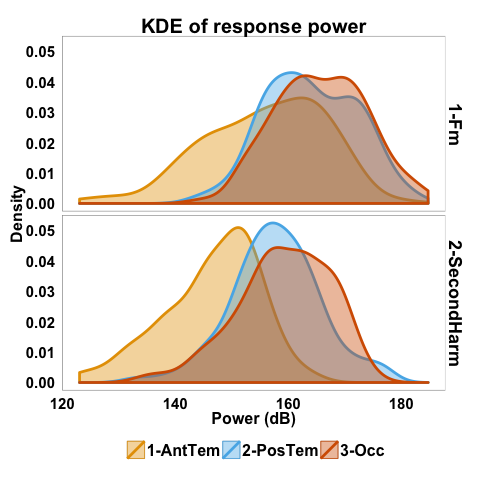

In [21]:
%%R 

ggplot(circlipse.pwr.data, aes(x = dBPwr)) +
  geom_density(aes(colour = Area, fill = Area), size = 1.3, alpha = 0.4) +
  labs(title = 'KDE of response power', x = 'Power (dB)', y = 'Density') +
  theme_bw() +
  scale_fill_manual(values = c(cbPalette[2], cbPalette[3],
                               cbPalette[7])) +
  scale_colour_manual(values = c(cbPalette[2], cbPalette[3],
                               cbPalette[7])) + 
  theme(strip.text = element_text(face = 'bold', size = rel(1.5)),
        strip.background=element_rect(fill = 'white', 
                                      colour = 'white', size = 1),
        legend.position = 'bottom',
        legend.text = element_text(face = 'bold', size = 16),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 15, face = 'bold'),
        axis.text.y = element_text(size = 15,face = 'bold'),
        axis.ticks = element_blank(),
        axis.title.x = element_text(size = 16, face = 'bold'),
        axis.title.y = element_text(size = 16, face = 'bold'),
        panel.grid.minor.x = element_blank(), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank(),
        plot.title = element_text(size = 20, face = 'bold')) +
  facet_grid(Harm ~ .)

## So what have we seen?

The KDEs have shown that the mean and standard error plots made sense given the variation and distribution seen. Importantly for the modeling we want to implement, the responses are (relatively) normally distributed, hopefully the errors will be also, and we know what types of planned comparisons should go into the model.

## Linear Mixed Modeling

To analyze the power of the response, we will employ a linear mixed model.

***Fixed effects***: `Hemisphere, Harmonic, Area, and Condition`  
***Random intercept***: `Subject`  
***Random slopes***: `Hemisphere, Harmonic, Condition`  

Why choose these random and fixed effects? Based on prior knowledge, we know that cerebral hemispheres can have different functions, especially in language-related or lanugage-alike tasks. For `Harmonic`, `Condition`, and `Area`, we want to know if there are any significant differences after accounting for `Subject` variation. Since each `Subject` might react differently or process the stimuli different according to `Hemisphere`, `Harmonic`, or `Condition`, we need to account for that, hence, the random slopes. For those more concerned about the theory, we have taken repeated measurements for `Hemisphere, Harmonic, Condition`. Even though the data do not support the idea that there are significant differences for some of these factors, we still need to test this, based on prior knowledge about cerebral processing.  

Mixed models are also good because MEG data is entirely-within subject. Some may say you run a mixed model because you have missing data; the latter is not true in this case and is still appropriate.

## Model specifications

Based on our prior knowledge, this will be our process:  
- create a main effects model
- create a model comprised of main effects and a `Sensor area : Harmonic` interaction
- compare models
- get significance of predictors for the model that explains the data better
- perform some diagnostics on the model fit  

Models will be fit via maximum likelihood.

In [22]:
%%R

# model fitting
library(lme4)

add.model <- 
  lmer(dBPwr ~ Hem + Harm + Cond + Area +
         (Hem + Harm + Cond | Subject), data = circlipse.pwr.data,
       REML = FALSE)

add.model.interact <- 
  lmer(dBPwr ~ Hem + Harm + Cond + Area + Harm:Area + 
         (Hem + Harm + Cond | Subject), data = circlipse.pwr.data,
       REML = FALSE)


Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:base’:

    crossprod, tcrossprod

Loading required package: Rcpp


In [23]:
%%R
anova(add.model, add.model.interact) # comparing models via log-likelihood tests

Data: circlipse.pwr.data
Models:
add.model: dBPwr ~ Hem + Harm + Cond + Area + (Hem + Harm + Cond | Subject)
add.model.interact: dBPwr ~ Hem + Harm + Cond + Area + Harm:Area + (Hem + Harm + 
add.model.interact:     Cond | Subject)
                   Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)  
add.model          30 4738.6 4873.9 -2339.3   4678.6                           
add.model.interact 32 4736.9 4881.2 -2336.4   4672.9 5.7237      2    0.05716 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


So we see that the model with the added interaction term does not pass a log-likelihood test as a better fit for the data. Thus, a main effects model is sufficient.

In [24]:
%%R
# summary table
summary(add.model)


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: dBPwr ~ Hem + Harm + Cond + Area + (Hem + Harm + Cond | Subject)
   Data: circlipse.pwr.data

     AIC      BIC   logLik deviance df.resid 
  4738.6   4873.9  -2339.3   4678.6      642 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7310 -0.5551  0.0703  0.6629  2.8085 

Random effects:
 Groups   Name             Variance Std.Dev. Corr                         
 Subject  (Intercept)      19.193   4.381                                 
          Hem2-rh           6.429   2.536    -0.22                        
          Harm2-SecondHarm 10.654   3.264    -0.75 -0.19                  
          Cond2-Zero        3.827   1.956     0.38 -0.26  0.15            
          Cond3-HalfPi      2.367   1.538    -0.57  0.56  0.55  0.34      
          Cond4-Pi          5.525   2.350    -0.13 -0.15  0.53  0.87  0.67
 Residual                  55.970   7.481                                 
Number of obs: 672, groups: 

In [25]:
%%R
library(car)

# predictor significance
Anova(add.model)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: dBPwr
        Chisq Df Pr(>Chisq)    
Hem    0.3151  1     0.5746    
Harm  49.5285  1  1.955e-12 ***
Cond   1.3428  3     0.7190    
Area 295.4192  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In line with our earlier plots, it seems that there is a significant difference between harmonics and between sensor (cortical) areas.

In [26]:
%%R

library(multcomp)

# Tukey HSD for multiple comparison procesdures
summary(glht(add.model, linfct = mcp(Hem = 'Tukey')))


Loading required package: mvtnorm
Loading required package: survival
Loading required package: TH.data

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = dBPwr ~ Hem + Harm + Cond + Area + (Hem + Harm + 
    Cond | Subject), data = circlipse.pwr.data, REML = FALSE)

Linear Hypotheses:
                 Estimate Std. Error z value Pr(>|z|)
2-rh - 1-lh == 0  -0.4997     0.8902  -0.561    0.575
(Adjusted p values reported -- single-step method)



In [27]:
%%R 

summary(glht(add.model, linfct = mcp(Harm = 'Tukey')))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = dBPwr ~ Hem + Harm + Cond + Area + (Hem + Harm + 
    Cond | Subject), data = circlipse.pwr.data, REML = FALSE)

Linear Hypotheses:
                         Estimate Std. Error z value Pr(>|z|)    
2-SecondHarm - 1-Fm == 0   -7.362      1.046  -7.038 1.96e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



In [28]:
%%R 
summary(glht(add.model, linfct = mcp(Cond = 'Tukey')))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = dBPwr ~ Hem + Harm + Cond + Area + (Hem + Harm + 
    Cond | Subject), data = circlipse.pwr.data, REML = FALSE)

Linear Hypotheses:
                       Estimate Std. Error z value Pr(>|z|)
2-Zero - 1-Uni == 0      0.8684     0.9694   0.896    0.805
3-HalfPi - 1-Uni == 0    0.9698     0.9140   1.061    0.711
4-Pi - 1-Uni == 0        0.7394     1.0300   0.718    0.889
3-HalfPi - 2-Zero == 0   0.1014     0.9820   0.103    1.000
4-Pi - 2-Zero == 0      -0.1290     0.8752  -0.147    0.999
4-Pi - 3-HalfPi == 0    -0.2305     0.9409  -0.245    0.995
(Adjusted p values reported -- single-step method)



In [29]:
%%R 
summary(glht(add.model, linfct = mcp(Area = 'Tukey')))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = dBPwr ~ Hem + Harm + Cond + Area + (Hem + Harm + 
    Cond | Subject), data = circlipse.pwr.data, REML = FALSE)

Linear Hypotheses:
                         Estimate Std. Error z value Pr(>|z|)    
2-PosTem - 1-AntTem == 0   9.6606     0.7069  13.666   <1e-04 ***
3-Occ - 1-AntTem == 0     11.2121     0.7069  15.861   <1e-04 ***
3-Occ - 2-PosTem == 0      1.5515     0.7069   2.195    0.072 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



## How well did the model fit the data?

We already saw this with the summary of the model above. Let's do it graphically with the residuals.

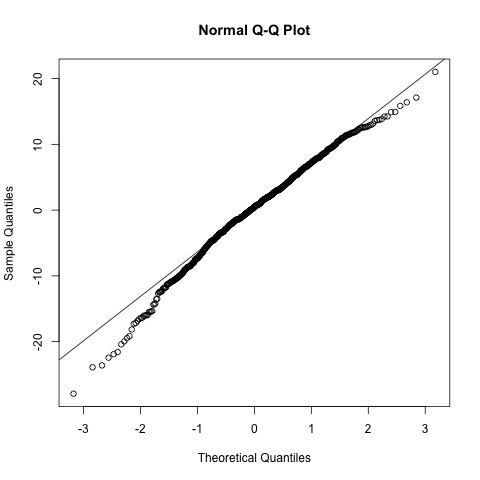

In [30]:
%%R 

# append fitted values and residuals
add.model.fortify <- fortify(add.model)


qqnorm(add.model.fortify$.resid)
qqline(add.model.fortify$.resid)

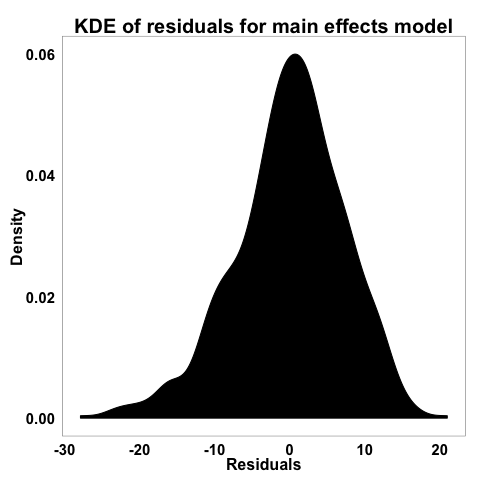

In [31]:
%%R
ggplot(add.model.fortify, aes(.resid)) + geom_density(fill = 'black') +
    labs(title = 'KDE of residuals for main effects model', y = 'Density', x = 'Residuals') +
    theme_bw() +
  theme(legend.position = 'bottom',
        legend.text = element_text(face = 'bold', size = 16),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 15, face = 'bold'),
        axis.text.y = element_text(size = 15,face = 'bold'),
        axis.ticks = element_blank(),
        axis.title.x = element_text(size = 16, face = 'bold'),
        axis.title.y = element_text(size = 16, face = 'bold'),
        panel.grid.minor.x = element_blank(), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank(),
        plot.title = element_text(size = 20, face = 'bold'))

Not perfect, but they are reasonably normally distributed. Those tails are worrisome, more so on the low than high end.

##Post hoc tests

In the original paper, we stated there was a significant interaction between Area and Harmonic and the topographic plots seem to bear this out. But the new calls do not. The model with the `Sensor Area:Harmonic` interaction has the interaction being marginally significant (p = 0.056). So some *post hoc* tests are in order to potentially resolve this issue.  

Let's start out with a more complicated LMM that more closely resembles what was done initially. The original idea was to fit the most complicated fully-crossed model and if that was not correct, eliminate terms.

In [32]:
%%R

full.model <- lmer(dBPwr ~ Hem * Harm * Cond * Area + (Hem + Harm + Cond | Subject),
                  data = circlipse.pwr.data, REML = FALSE)


In [33]:
%R print(Anova(full.model))

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: dBPwr
                      Chisq Df Pr(>Chisq)    
Hem                  0.3168  1    0.57352    
Harm                49.5455  1  1.938e-12 ***
Cond                 1.4128  3    0.70255    
Area               323.3870  2  < 2.2e-16 ***
Hem:Harm             0.8427  1    0.35863    
Hem:Cond             0.3907  3    0.94215    
Harm:Cond            3.2784  3    0.35066    
Hem:Area             7.2462  2    0.02670 *  
Harm:Area            6.2366  2    0.04423 *  
Cond:Area           30.3672  6  3.347e-05 ***
Hem:Harm:Cond        2.1540  3    0.54107    
Hem:Harm:Area        1.3491  2    0.50938    
Hem:Cond:Area        1.2508  6    0.97430    
Harm:Cond:Area       3.0376  6    0.80412    
Hem:Harm:Cond:Area   2.1644  6    0.90397    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Hmmmm. So it seems that there are significant effects of `Harmonic` and `Area` (good) and significant interactions of `Hem:Area`, `Harm:Area` and `Cond:Area`.  What should happen next?

Well, first, simplify this particular model by keeping only the significant terms and those we include based on prior biological knowledge. Then, let's compare to the main effects model from previously. If it passes a log-likelihood test, then let's keep the model and peform Tukey HSD. I suspect that `Harm:Area` is not siginificant, as it has been on either side of our threshold in two different models, but you never know. Other data (*F* tests on harmonic power in the paper and the topographic plots) indicate it is, which suggests that the effect size is not that large if it is significant.

In [34]:
%%R

interact.model.parsim <- lmer(dBPwr ~ Hem + Harm + Cond + Area + Hem:Area + Harm:Area + Cond:Area +
                             (Hem + Harm + Cond | Subject), data = circlipse.pwr.data, REML = FALSE)

In [35]:
%R print(anova(add.model, interact.model.parsim))

Data: circlipse.pwr.data
Models:
add.model: dBPwr ~ Hem + Harm + Cond + Area + (Hem + Harm + Cond | Subject)
interact.model.parsim: dBPwr ~ Hem + Harm + Cond + Area + Hem:Area + Harm:Area + Cond:Area + 
interact.model.parsim:     (Hem + Harm + Cond | Subject)
                      Df    AIC    BIC  logLik deviance  Chisq Chi Df
add.model             30 4738.6 4873.9 -2339.3   4678.6              
interact.model.parsim 40 4717.2 4897.6 -2318.6   4637.2 41.419     10
                      Pr(>Chisq)    
add.model                           
interact.model.parsim  9.509e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Kind of hard to see, but it does pass a log-likehood test. Let's keep going.

In [36]:
%R print(summary(glht(interact.model.parsim, linfct = mcp(Hem = 'Tukey', interaction_average = TRUE))))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = dBPwr ~ Hem + Harm + Cond + Area + Hem:Area + 
    Harm:Area + Cond:Area + (Hem + Harm + Cond | Subject), data = circlipse.pwr.data, 
    REML = FALSE)

Linear Hypotheses:
                 Estimate Std. Error z value Pr(>|z|)
2-rh - 1-lh == 0  -0.4997     0.8883  -0.562    0.574
(Adjusted p values reported -- single-step method)



In [37]:
%R print(summary(glht(interact.model.parsim, linfct = mcp(Harm = 'Tukey', interaction_average = TRUE))))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = dBPwr ~ Hem + Harm + Cond + Area + Hem:Area + 
    Harm:Area + Cond:Area + (Hem + Harm + Cond | Subject), data = circlipse.pwr.data, 
    REML = FALSE)

Linear Hypotheses:
                         Estimate Std. Error z value Pr(>|z|)    
2-SecondHarm - 1-Fm == 0   -7.362      1.046  -7.039 1.94e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



In [38]:
%R print(summary(glht(interact.model.parsim, linfct = mcp(Cond = 'Tukey', interaction_average = TRUE))))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = dBPwr ~ Hem + Harm + Cond + Area + Hem:Area + 
    Harm:Area + Cond:Area + (Hem + Harm + Cond | Subject), data = circlipse.pwr.data, 
    REML = FALSE)

Linear Hypotheses:
                       Estimate Std. Error z value Pr(>|z|)
2-Zero - 1-Uni == 0      0.8684     0.9543   0.910    0.797
3-HalfPi - 1-Uni == 0    0.9698     0.8971   1.081    0.698
4-Pi - 1-Uni == 0        0.7394     1.0298   0.718    0.889
3-HalfPi - 2-Zero == 0   0.1014     0.9635   0.105    1.000
4-Pi - 2-Zero == 0      -0.1290     0.8552  -0.151    0.999
4-Pi - 3-HalfPi == 0    -0.2305     0.9263  -0.249    0.995
(Adjusted p values reported -- single-step method)



In [39]:
%R print(summary(glht(interact.model.parsim, linfct = mcp(Area = 'Tukey', interaction_average = TRUE))))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = dBPwr ~ Hem + Harm + Cond + Area + Hem:Area + 
    Harm:Area + Cond:Area + (Hem + Harm + Cond | Subject), data = circlipse.pwr.data, 
    REML = FALSE)

Linear Hypotheses:
                         Estimate Std. Error z value Pr(>|z|)    
2-PosTem - 1-AntTem == 0   9.6606     0.6835   14.13   <0.001 ***
3-Occ - 1-AntTem == 0     11.2121     0.6835   16.40   <0.001 ***
3-Occ - 2-PosTem == 0      1.5515     0.6835    2.27     0.06 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



In [40]:
%R print(Anova(interact.model.parsim))

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: dBPwr
             Chisq Df Pr(>Chisq)    
Hem         0.3164  1    0.57378    
Harm       49.5413  1  1.942e-12 ***
Cond        1.3943  3    0.70687    
Area      315.9661  2  < 2.2e-16 ***
Hem:Area    7.0799  2    0.02901 *  
Harm:Area   6.0935  2    0.04751 *  
Cond:Area  29.6703  6  4.541e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


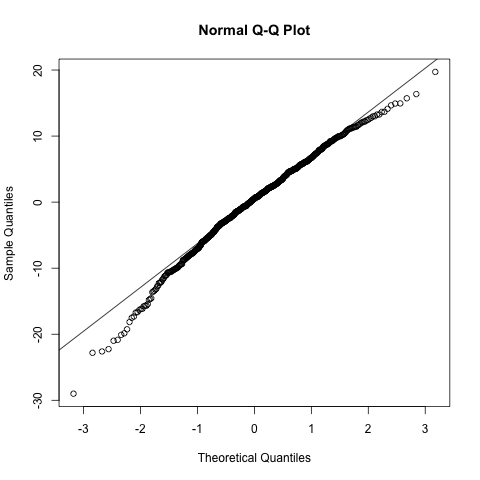

In [41]:
%%R 

interact.model.parsim.fortify <- fortify(interact.model.parsim)

write.csv(interact.model.parsim.fortify, 'circlipses-parsimonious-model-data.csv', row.names = FALSE)

qqnorm(interact.model.parsim.fortify$.resid)
qqline(interact.model.parsim.fortify$.resid)

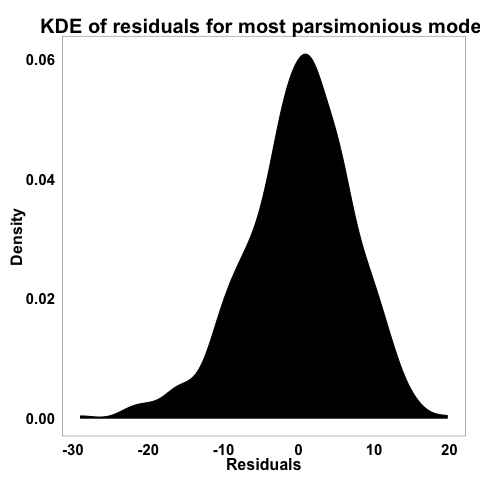

In [42]:
%%R
ggplot(interact.model.parsim.fortify, aes(.resid)) + geom_density(fill = 'black') +
    labs(title = 'KDE of residuals for most parsimonious model', y = 'Density', x = 'Residuals') +
    theme_bw() +
  theme(legend.position = 'bottom',
        legend.text = element_text(face = 'bold', size = 16),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 15, face = 'bold'),
        axis.text.y = element_text(size = 15,face = 'bold'),
        axis.ticks = element_blank(),
        axis.title.x = element_text(size = 16, face = 'bold'),
        axis.title.y = element_text(size = 16, face = 'bold'),
        panel.grid.minor.x = element_blank(), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank(),
        plot.title = element_text(size = 20, face = 'bold'))

Next, let's revisit the figures with the main effect: Figures 7-9.

In [43]:
%%R 

cond.area.harm.pwr <- 
  ddply(circlipse.pwr.data, .(Cond, Area, Harm), summarize,
        n = sum(complete.cases(dBPwr)),
        meanPwr = mean(dBPwr, na.rm = TRUE), 
        sePwr = sd(dBPwr,na.rm = TRUE)/sqrt(n))

cond.area.harm.pwr

       Cond     Area         Harm  n  meanPwr    sePwr
1     1-Uni 1-AntTem         1-Fm 28 156.0327 2.124751
2     1-Uni 1-AntTem 2-SecondHarm 28 148.8750 1.198035
3     1-Uni 2-PosTem         1-Fm 28 159.9849 1.361394
4     1-Uni 2-PosTem 2-SecondHarm 28 153.2813 1.120988
5     1-Uni    3-Occ         1-Fm 28 166.8145 1.507314
6     1-Uni    3-Occ 2-SecondHarm 28 160.2046 1.311619
7    2-Zero 1-AntTem         1-Fm 28 155.8431 1.943045
8    2-Zero 1-AntTem 2-SecondHarm 28 146.7424 1.948752
9    2-Zero 2-PosTem         1-Fm 28 164.8616 1.650536
10   2-Zero 2-PosTem 2-SecondHarm 28 159.9719 1.480959
11   2-Zero    3-Occ         1-Fm 28 163.8998 1.562129
12   2-Zero    3-Occ 2-SecondHarm 28 159.0845 1.629663
13 3-HalfPi 1-AntTem         1-Fm 28 155.7216 1.760851
14 3-HalfPi 1-AntTem 2-SecondHarm 28 144.6722 1.759254
15 3-HalfPi 2-PosTem         1-Fm 28 164.9874 1.472830
16 3-HalfPi 2-PosTem 2-SecondHarm 28 159.7694 1.446070
17 3-HalfPi    3-Occ         1-Fm 28 165.9116 1.487651
18 3-HalfP

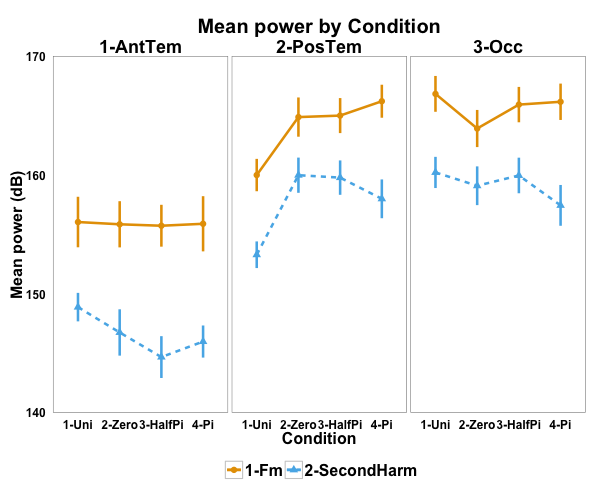

In [44]:
%%R -w 600 -h 500 -u px

ggplot(cond.area.harm.pwr, aes(x = Cond, y = meanPwr, group = Harm)) +
  geom_point(aes(colour = Harm, shape = Harm), size = 3) + 
  geom_linerange(size = 1.2, 
                aes(ymin = meanPwr - sePwr, ymax = meanPwr + sePwr,
                   colour = Harm)) +
  geom_line(aes(colour = Harm, linetype = Harm), size = 1.2) + 
  theme_bw() +
  labs(x = 'Condition', y = 'Mean power (dB)',
       title = 'Mean power by Condition', face = 'bold', size = 20) +
  scale_fill_manual(values = c(cbPalette[2], cbPalette[3],
                               cbPalette[7])) + 
  scale_colour_manual(values = c(cbPalette[2], cbPalette[3],
                                 cbPalette[7])) + 
  theme(strip.text = element_text(face = 'bold', size = rel(1.5)),
        strip.background=element_rect(fill = 'white', 
                                      colour = 'white', size = 1),
        legend.position = 'bottom',
        legend.text = element_text(face = 'bold', size = 16),
        legend.title = element_blank(),
        axis.text.x = element_text(size = 12, face = 'bold'),
        axis.text.y = element_text(size = 12,face = 'bold'),
        axis.ticks = element_blank(),
        axis.title.x = element_text(size = 16, face = 'bold'),
        axis.title.y = element_text(size = 16, face = 'bold'),
        panel.grid.minor.x = element_blank(), 
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank(),
        plot.title = element_text(size = 20, face = 'bold')) +
  coord_cartesian(ylim = c(140, 170)) +
  facet_grid(. ~ Area)

So, through the power of statistics, careful data exploration and model choosing, we have replicated and built on the previous findings. But we are not done yet.  

If you think carefully about it, this is a really small sample size. How do we know what we have observed is what is really going on? Is there a way to do this?  

What is going to happen next is that we are want to use ***Bayesian inference*** to tell us what the 'true' values of the powers might be. Thankfully, our data are rather well-behaved for this kind of analysis (no funky distributions we would have to specifiy ourselves), so estimating the true distribution of response powers will be relatively straightforward.

## Bayesian inference on response power distributions

Since we are sampling from a larger population, and there are certain caveats about our population (demographics, education, reasons for paricipation), we have some uncertainty and want to correct for this. We will use the observed means as priors, model the decibel power distributions as normal distributions and then see what the posterior values are.

I am new to this, and to my knowledge, this has not been done before with MEG data of this type. To keep things simple, let's focus on the overall distribution and the distribution between harmonics.  

Steps:
- use observed values as priors
- use PyMC to perform model setup and MCMC sampling
- use values from posterior distribution to for 'true' value

In [45]:
# values of means and standard deviations (pre-calculated); could also base off effect sizes from model

overall_mean = 158.1766
overall_sd = 10.59207

first_harm_mean = 161.8573
first_harm_sd = 9.954104

second_harm_mean = 154.4958
second_harm_sd = 9.922567

First thing to do is make some educated guesses as to what we want. We will use the calculated means and standard deviations as the priors. For the simulations, we will draw our standard deviations (tau; 1/variance) from a uniform distribution and for the means, from Gaussians close to the observed values

In [46]:
import pandas as pd
data_path = '/Users/julian/Documents/R_info/'

# import dataset
circlipse_pwr_data = pd.read_csv(data_path + 'circlipse-pwr-data-final-2015.csv')

overall_pwr = circlipse_pwr_data.dBPwr.values

overall_pwr[:20]

print 'Oberved mean power: ', overall_pwr.mean()
print 'Observed standard deviation: ', overall_pwr.std()

Oberved mean power:  158.176561042
Observed standard deviation:  10.5841845964


This section will import the Python module used for MCMC sampling as well as set up the model being used. Instead of specifying the standard deviation, the inverse of the variance will be used; this is called the precision.  There are 200000 iterations, with an initial burn of 80000 and thinning of 10.

In [47]:
# start bulding for MCMC sampling
import pymc as pm


# specify priors for tau and center (mu)
overall_tau = pm.Uniform('stds', 5, 15, value = [7]) ** -2
overall_center = pm.Normal('center', 162, 0.12)

# observations will be the data 
observations = pm.Normal('obs', overall_center, overall_tau, value = overall_pwr, observed = True)

print 'Prior for tau: ', overall_tau.value
print 'Prior for center (mu): ', overall_center.value

Couldn't import dot_parser, loading of dot files will not be possible.
Prior for tau:  [ 0.02040816]
Prior for center (mu):  160.711176553


In [48]:
# implement MCMC sampling
model = pm.Model([observations, overall_tau, overall_center])
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(200000, burn = 80000, thin = 10)

 [-----------------100%-----------------] 200000 of 200000 complete in 28.1 sec

Now what to do? We want to look at the traces of the MCMC sampling, examine the posterior distributions, and if there is no need to reset parameters or re-simulate, use the values from the posterior distributions to get our true values for the overall power. After that, let's do the same for differences between harmonics.

In [49]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from pymc.Matplot import plot as mcplot

Plotting center


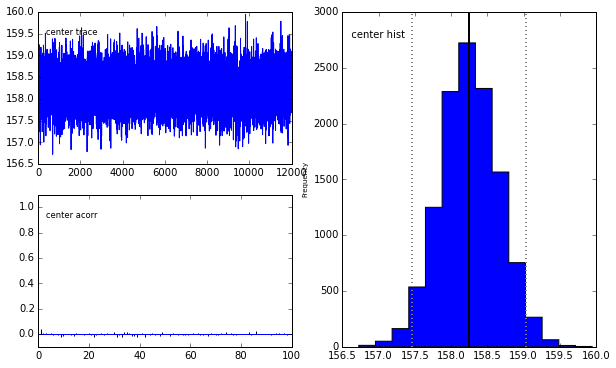

In [50]:
# plot for the mean
mcplot(mcmc.trace('center'), common_scale = False)

Plotting stds_0


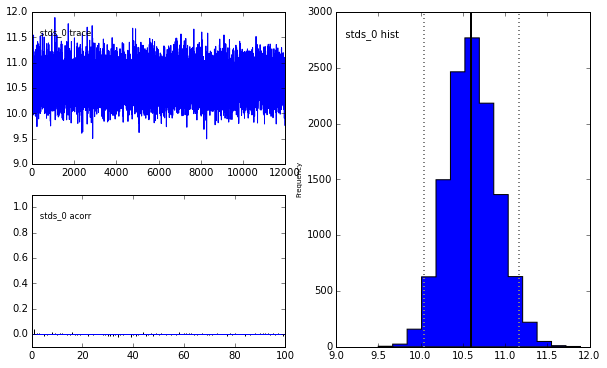

In [51]:
# plot for the standard deviation
mcplot(mcmc.trace('stds'), common_scale = False)

The above plots indicate that the MCMC estimtates are close to what was observed. Maybe this was because our priors were pretty close to the observed data. Or perhaps because the experiment was really well-designed and the response between subjects was consistent. Though it might have been better to look at this initially, let's examine the distribution for each subject.

Subject
r1414    Axes(0.125,0.125;0.775x0.775)
r1532    Axes(0.125,0.125;0.775x0.775)
r1533    Axes(0.125,0.125;0.775x0.775)
r1540    Axes(0.125,0.125;0.775x0.775)
r1542    Axes(0.125,0.125;0.775x0.775)
r1547    Axes(0.125,0.125;0.775x0.775)
r1548    Axes(0.125,0.125;0.775x0.775)
r1549    Axes(0.125,0.125;0.775x0.775)
r1551    Axes(0.125,0.125;0.775x0.775)
r1552    Axes(0.125,0.125;0.775x0.775)
r1557    Axes(0.125,0.125;0.775x0.775)
r1563    Axes(0.125,0.125;0.775x0.775)
r1565    Axes(0.125,0.125;0.775x0.775)
r1567    Axes(0.125,0.125;0.775x0.775)
Name: dBPwr, dtype: object

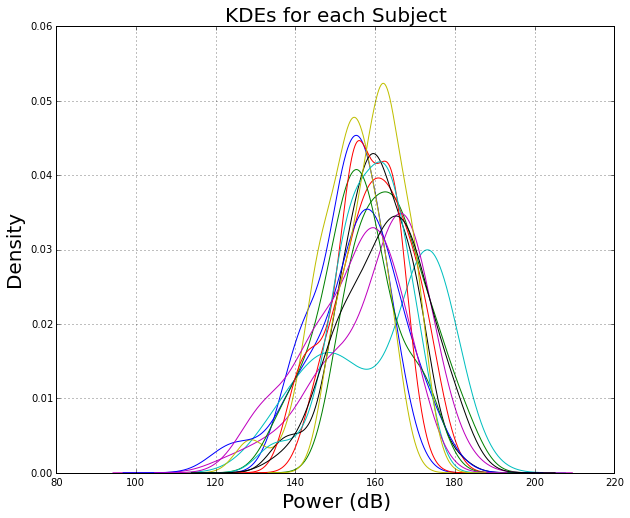

In [52]:
# caluculate density for each Subject and plot

subject_group = circlipse_pwr_data.groupby(['Subject'])

figsize(10, 8)
plt.title('KDEs for each Subject', size = 20)
plt.xlabel('Power (dB)', size = 20)
plt.ylabel('Density', size = 20)
subject_group['dBPwr'].plot(kind = 'kde')

Aside from one subject with a bimodal power distribution, the data are consistent across subjects. It could be argued that there is also some skewness with some of the subjects, but visual inspection and maybe some sort of outlier detection would not suggest removal from the dataset.  

So let's choose new priors and re-run. Instead of using the mean and standard deviation from the raw measurements, let's use the *fitted* values from the mixed model as the basis (the mean of the fitted values will be identical to that of the obsrved values). And on top of that, let's widen the range of values we consider and consider draw both the mean and the standard deviation from uniform distributions.

In [53]:
column_names = \
  ['Subject', 'Hem', 'Harm', 'Cond', 'Area', 'LinPwr', 'dBPwr', 'Fitted', 'Resid', 'ScaledResid']

circlipse_pwr_data_fortify = \
  pd.read_csv(data_path + 'circlipses-parsimonious-model-data.csv', 
              names = column_names, header = 0)

circlipse_pwr_data_fortify.head()

,Subject,Hem,Harm,Cond,Area,LinPwr,dBPwr,Fitted,Resid,ScaledResid
0,r1532,1-lh,1-Fm,1-Uni,1-AntTem,4.310000e+15,156.346485,163.382579,-7.036094,-0.972645
1,r1532,1-lh,1-Fm,1-Uni,2-PosTem,2.890000e+15,154.613935,165.834093,-11.220158,-1.551035
2,r1532,1-lh,1-Fm,1-Uni,3-Occ,2.970000e+18,184.734286,174.512610,10.221676,1.413009
3,r1532,1-lh,1-Fm,2-Zero,1-AntTem,4.370000e+16,166.407596,165.093625,1.313971,0.181639
4,r1532,1-lh,1-Fm,2-Zero,2-PosTem,2.060000e+17,173.144150,174.489886,-1.345736,-0.186030


In [54]:
fitted_mean = circlipse_pwr_data_fortify.Fitted.mean()
fitted_std = circlipse_pwr_data_fortify.Fitted.std()

print 'Mean of fitted values: ', fitted_mean
print 'Standard deviation of fitted values: ', fitted_std

Mean of fitted values:  158.176561042
Standard deviation of fitted values:  7.55591938498


In [55]:
# specify priors for tau and center (mu)
fitted_tau = pm.Uniform('stds', 0, 18) ** -2
fitted_center = pm.Uniform('center', 150, 165)

# observations will be the data 
observations = pm.Normal('obs', fitted_center, fitted_tau, value = overall_pwr, observed = True)

print 'Prior for tau: ', fitted_tau.value
print 'Prior for center (mu): ', fitted_center.value

Prior for tau:  0.0113963167818
Prior for center (mu):  158.87293651


In [56]:
# implement MCMC sampling
fitted_model = pm.Model([observations, fitted_tau, fitted_center])
fitted_map_ = pm.MAP(fitted_model)
fitted_map_.fit()
fitted_mcmc = pm.MCMC(fitted_model)
fitted_mcmc.sample(200000, burn = 80000, thin = 10)

 [-----------------100%-----------------] 200000 of 200000 complete in 28.7 sec

Plotting center


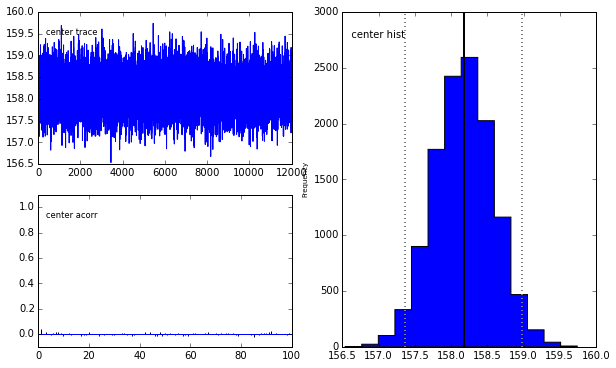

In [57]:
# plot for posterior of the mean
mcplot(fitted_mcmc.trace('center'), common_scale = False)

Plotting stds


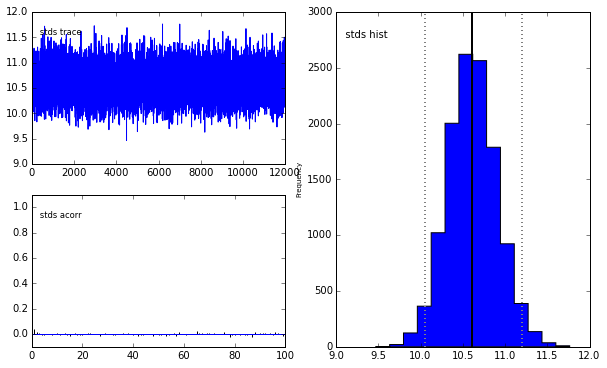

In [58]:
# plot for posterior of standard deviation
mcplot(fitted_mcmc.trace('stds'), common_scale = False)

So it seems that we get simmilar results despite our changing the priors and the distributions used in our simulations. What values for the priors did we get as a result of the simulations?

In [59]:
print 'Posterior estimate of mean for original simulation: ', mcmc.trace('center')[:].mean()
print 'Posterior estimate of standard deviation for original simulation: ', mcmc.trace('stds')[:].mean()

print 'Posterior estimate of mean for second simulation: ', fitted_mcmc.trace('center')[:].mean()
print 'Posterior estimate of standard deviation of posterior for second simulation: ', fitted_mcmc.trace('stds')[:].mean()

Posterior estimate of mean for original simulation:  158.255285587
Posterior estimate of standard deviation for original simulation:  10.6067361661
Posterior estimate of mean for second simulation:  158.175709636
Posterior estimate of standard deviation of posterior for second simulation:  10.6121734843


If we wanted to go further down the rabbit hole, we could perform the same procedure for the fitted values derived from the LMM applied to the data. Maybe save that for a separate, later, analysis...  

Now let's repeat this, but separate the data out by harmonic.

In [60]:
# take subsets of data according to harmonic

first_harm = circlipse_pwr_data_fortify[circlipse_pwr_data_fortify.Harm.isin(['1-Fm'])]
second_harm = circlipse_pwr_data_fortify[circlipse_pwr_data_fortify.Harm.isin(['2-SecondHarm'])]

first_harm.head()

,Subject,Hem,Harm,Cond,Area,LinPwr,dBPwr,Fitted,Resid,ScaledResid
0,r1532,1-lh,1-Fm,1-Uni,1-AntTem,4.310000e+15,156.346485,163.382579,-7.036094,-0.972645
1,r1532,1-lh,1-Fm,1-Uni,2-PosTem,2.890000e+15,154.613935,165.834093,-11.220158,-1.551035
2,r1532,1-lh,1-Fm,1-Uni,3-Occ,2.970000e+18,184.734286,174.512610,10.221676,1.413009
3,r1532,1-lh,1-Fm,2-Zero,1-AntTem,4.370000e+16,166.407596,165.093625,1.313971,0.181639
4,r1532,1-lh,1-Fm,2-Zero,2-PosTem,2.060000e+17,173.144150,174.489886,-1.345736,-0.186030


In [61]:
first_harm_data = first_harm.dBPwr.values
second_harm_data = second_harm.dBPwr.values

In [62]:
first_harm_mean = first_harm_data.mean()
first_harm_std = first_harm_data.std()

second_harm_mean = second_harm_data.mean()
second_harm_std = second_harm_data.std()

print 'Observed mean for first harmonic: ', first_harm_mean
print 'Observed standard deviation for first harmonic: ', first_harm_std
print 'Observed mean for second harmonic: ', second_harm_mean
print 'Observed standard deviation for second harmonic: ', second_harm_std


Observed mean for first harmonic:  161.857344574
Observed standard deviation for first harmonic:  9.93928000141
Observed mean for second harmonic:  154.495777509
Observed standard deviation for second harmonic:  9.90779013523


In [63]:
# specify priors for tau and center (mu)
first_harm_tau = pm.Uniform('std', 0, 20) ** -2
first_harm_center = pm.Uniform('center', 150, 170)

second_harm_tau = pm.Uniform('std', 0, 20) ** -2
second_harm_center = pm.Uniform('center', 145, 155)

# observations 
first_harm_obs = pm.Normal('obs', first_harm_center, first_harm_tau, value = first_harm_data, observed = True)
second_harm_obs = pm.Normal('obs', second_harm_center, second_harm_tau, value = second_harm_data, observed = True)

print 'Prior for first harmonic tau: ', first_harm_tau.value
print 'Prior for first harmonic center: ', first_harm_center.value
print 'Prior for second harmonic tau: ', second_harm_tau.value
print 'Prior for second harmonic center: ', second_harm_center.value

Prior for first harmonic tau:  0.00516766687663
Prior for first harmonic center:  150.294243544
Prior for second harmonic tau:  0.00345751369495
Prior for second harmonic center:  149.355965514


In [64]:
# MCMC samping for first harmonic data

# first harmonic
first_harm_model = pm.Model([first_harm_obs, first_harm_tau, first_harm_center])
first_harm_map_ = pm.MAP(first_harm_model)
first_harm_map_.fit()
first_harm_mcmc = pm.MCMC(first_harm_model)
first_harm_mcmc.sample(200000, burn = 80000, thin = 10)

 [-----------------100%-----------------] 200000 of 200000 complete in 25.5 sec

In [65]:
# MCMC samping for second harmonic data

# second harmonic
second_harm_model = pm.Model([second_harm_obs, second_harm_tau, second_harm_center])
second_harm_map_ = pm.MAP(second_harm_model)
second_harm_map_.fit()
second_harm_mcmc = pm.MCMC(second_harm_model)
second_harm_mcmc.sample(200000, burn = 80000, thin = 10)

 [-----------------100%-----------------] 200000 of 200000 complete in 25.0 sec

Plotting center
Plotting std


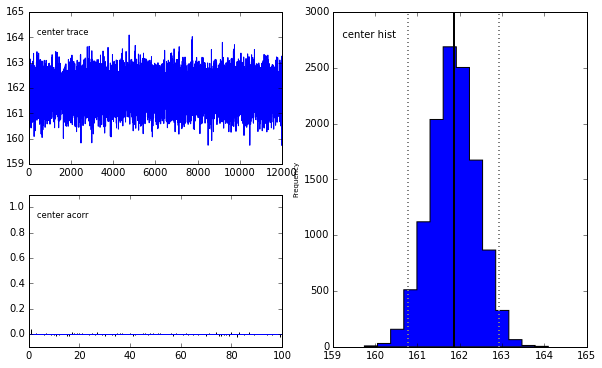

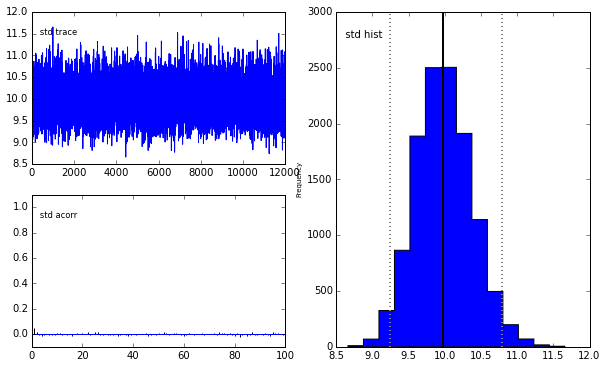

In [66]:
# first harmonic plots
mcplot(first_harm_mcmc.trace('center'), common_scale = False)
mcplot(first_harm_mcmc.trace('std'), common_scale = False)

Plotting center
Plotting std


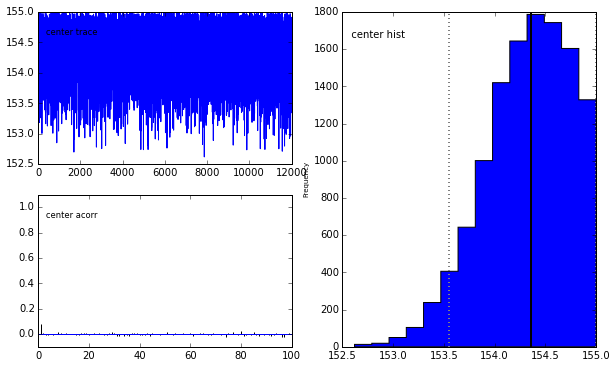

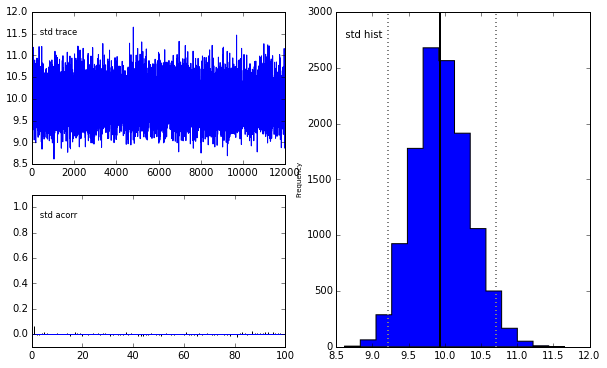

In [67]:
# second harmonic plots
mcplot(second_harm_mcmc.trace('center'), common_scale = False)
mcplot(second_harm_mcmc.trace('std'), common_scale = False)

In [68]:
print 'Posterior estimate of mean for first harmonic: ', first_harm_mcmc.trace('center')[:].mean()
print 'Posterior estimate of standard deviation for first harmonic: ', first_harm_mcmc.trace('std')[:].mean()
print 'Posterior estimate of mean for second harmonic: ', second_harm_mcmc.trace('center')[:].mean()
print 'Posterior estimate of standard deviation for second harmonic: ', second_harm_mcmc.trace('std')[:].mean()

Posterior estimate of mean for first harmonic:  161.85594061
Posterior estimate of standard deviation for first harmonic:  9.98914951772
Posterior estimate of mean for second harmonic:  154.320101796
Posterior estimate of standard deviation for second harmonic:  9.95454069523


The MCMC estimates agree well with what was observed in the subject pool and what was fitted with the LMM. Means we can be pretty confident in our analyses, though a larger sample size would be much nicer, but the Bayesian inference was a good way to further analyze and validate our data.

##Conclusion

In summary, we did the following:
- basic exploratory of the data on hand
- made defensible, if not sensible, LMM model calls based on prior knowledge about brain processing and subject variation within the experimental design
- added another layer of analysis based on the limiations of our sample  

That being said, the big issue is that of sample. Fourteen subjects might be sufficient academically, but another 14 - 20 subjects would make the conclusions more confident (if the effects are preserved). The small standard errors (raw data, fitted values, posterior distributions) may be either a function of the small sample size or the fact that the responses were remarkably conistent across subjects. No way to tell without more data.

Astute observers may have noticed is that we only looked at the significance of the interactions, not their effect sizes. Well, we can get that from the model summary, but no Tukey HSD was carried out. That could be done, but I would need more confidence in my constructing contrast matrices (the `multcomp` documentation spells out how to do this). That could be done when evaluating the model itself and the results (fitted values and residuals) from the model. Another useful analysis is to add the means to residuals for our comparisons of interest, and see if the variance between factor levels for that distribution is significant.  

In total, we now have a template on how to analyze data of this type, from descriptive stats, to model fitting and significance, to validating our results. Whether or not a reviewer understands or accepts the results and analyses is another thing, but the arc of science bends towards correct, sophisticted analysis.

### References
Jenkins 3rd et al., 2011. The Elicitation of Audiovisual Steady-State Responses: Multi- Sensory Signal Congruity and Phase Effects. Brain Topography, Vol 24, Issue 2 pp. 134-148. http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4125209/

Rhone, Ariane E., 2011. Multi-Level Audio-Visual Interactions in Speech and Language Perception. (*One chapter contains the 'pilot' version of the experiment where kinks and considerations were worked out*). http://drum.lib.umd.edu/handle/1903/12039

Jenkins III, 2011. MEG, Psychophysical and Computational studies of loudness, timbre, and audiovisual integration.  http://drum.lib.umd.edu/handle/1903/12084

Davidson-Pilon, Cam. Probabilistic Programming & Bayesian Methods for Hackers. http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/

In [69]:
%R print(sessionInfo())

R version 3.1.3 (2015-03-09)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: OS X 10.9.5 (Mavericks)

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] multcomp_1.4-0  TH.data_1.0-6   survival_2.38-1 mvtnorm_1.0-2  
 [5] car_2.0-25      lme4_1.1-7      Rcpp_0.11.6     Matrix_1.2-0   
 [9] ggplot2_1.0.1   plyr_1.8.2      readr_0.1.0    

loaded via a namespace (and not attached):
 [1] codetools_0.2-11 colorspace_1.2-6 curl_0.5         digest_0.6.8    
 [5] grid_3.1.3       gtable_0.1.2     labeling_0.3     lattice_0.20-31 
 [9] magrittr_1.5     MASS_7.3-40      mgcv_1.8-6       minqa_1.2.4     
[13] munsell_0.4.2    nlme_3.1-120     nloptr_1.0.4     nnet_7.3-9      
[17] parallel_3.1.3   pbkrtest_0.4-2   proto_0.3-10     quantreg_5.11   
[21] reshape2_1.4.1   sandwich_2.3-3   scales_0.2.4     SparseM_1.6     


In [70]:
import IPython
IPython.__version__

'3.1.0'

In [71]:
print 'PyMC version:', pm.__version__
print 'pandas version:', pd.__version__

PyMC version: 2.3.4
pandas version: 0.16.1
